# This notebook is to train the models and test them

In [ ]:
import pandas as pd
import numpy as np 
import copy
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import json
import seaborn as sns
from collections import defaultdict
from google.colab import drive
import statistics
drive.mount('/content/drive')

Mounted at /content/drive


drive/  sample_data/


In [ ]:
!pip install Arabic-Stopwords

     |████████████████████████████████| 353 kB 4.1 MB/s 
     |████████████████████████████████| 126 kB 52.5 MB/s 


In [ ]:
arabic_stop_words=[]
with open('/content/drive/MyDrive/Capstone Project Files CS/Datasets/arabic_stop_words.txt') as file:
    for line in file:
        arabic_stop_words.append(line.rstrip())

In [ ]:
len(arabic_stop_words)
print(arabic_stop_words[0:20])

['،', 'ء', 'ءَ', 'آ', 'آب', 'آذار', 'آض', 'آل', 'آمينَ', 'آناء', 'آنفا', 'آه', 'آهاً', 'آهٍ', 'آهِ', 'أ', 'أبدا', 'أبريل', 'أبو', 'أبٌ']


Dataset

In [ ]:
dataset= pd.read_csv('/content/drive/MyDrive/Capstone Project Files CS/Datasets/Processed Datasets/project_dataset_withNERSTEM.csv')

In [ ]:
dataset.head(5)

,Unnamed: 0,origin,tweet_text,tweet_text_NER,tweet_text_NER_STEM,label
0,0,ARC,الكورونا الطريقة الصحيحة لاستخدام الكمامات لاح...,الكورونا الطريقة الصحيحة لاستخدام الكمامات لاح...,كورونا طريقة صحيح استخدام كمام لاحظ عام ناس ما...,False
1,1,MFH,كونا | إصابة أنثى نمر في حديقة حيوان بمدينة (ن...,PER | إصابة أنثى نمر في حديقة حيوان بمدينة (...,PER | إصابة أنثى مر في حديقة حيوان مدينة ( LOC...,True
2,2,ARC,في مشهد مهيب تقشعر له الأبدان. خرج العاملون في...,في مشهد مهيب تقشعر له الأبدان. خرج العاملون في...,في مشهد مهيب تقشعر ل بدن . خرج عامل في مستشفى ...,True
3,3,4IF,بعد كسر حاجز 10000 أصابه نشطة في قطر ،، وزارة ...,بعد كسر حاجز 10000 أصابه نشطة في LOC ،، وزار...,بعد كسر حاجز 10000 أصاب نشط في LOC ، ، وزارة ت...,True
4,4,ARC,الواضح من الأرقام أن كورونا_الجديد COVID 19 يع...,الواضح من الأرقام أن MISC MISC يعرض المدخن...,واضح من رقم أن MISC MISC عرض مدخن كبير سن مرض ...,True


In [ ]:
dataset=dataset.drop(labels='Unnamed: 0', axis=1)

In [ ]:
columns_titles = ["origin","tweet_text", 'tweet_text_NER','tweet_text_NER_STEM', 'label']
dataset=dataset.reindex(columns=columns_titles)

In [ ]:
dataset.head(5)

,origin,tweet_text,tweet_text_NER,tweet_text_NER_STEM,label
0,ARC,الكورونا الطريقة الصحيحة لاستخدام الكمامات لاح...,الكورونا الطريقة الصحيحة لاستخدام الكمامات لاح...,كورونا طريقة صحيح استخدام كمام لاحظ عام ناس ما...,False
1,MFH,كونا | إصابة أنثى نمر في حديقة حيوان بمدينة (ن...,PER | إصابة أنثى نمر في حديقة حيوان بمدينة (...,PER | إصابة أنثى مر في حديقة حيوان مدينة ( LOC...,True
2,ARC,في مشهد مهيب تقشعر له الأبدان. خرج العاملون في...,في مشهد مهيب تقشعر له الأبدان. خرج العاملون في...,في مشهد مهيب تقشعر ل بدن . خرج عامل في مستشفى ...,True
3,4IF,بعد كسر حاجز 10000 أصابه نشطة في قطر ،، وزارة ...,بعد كسر حاجز 10000 أصابه نشطة في LOC ،، وزار...,بعد كسر حاجز 10000 أصاب نشط في LOC ، ، وزارة ت...,True
4,ARC,الواضح من الأرقام أن كورونا_الجديد COVID 19 يع...,الواضح من الأرقام أن MISC MISC يعرض المدخن...,واضح من رقم أن MISC MISC عرض مدخن كبير سن مرض ...,True


In [ ]:

##
'''
dataset size = 4838
Train 60% = 4838 * 0.6 = 2902.8 -> 2903
Validation 20% = 4838 * 0.2 = 967.6 -> 968
Training 20% =  967
3870.4 -> 3871
3871 *0.25 = 967.75 -> 968
3871*0.75 = 2903.25 -> 2903
967

80
'''
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)


In [ ]:
print("Train:",len(train_set), "\n" ,train_set['label'].value_counts(),"\n")
print("Test:",len(test_set), "\n", test_set['label'].value_counts(),"\n")

Train: 3870 
 True     1939
False    1931
Name: label, dtype: int64 

Test: 968 
 False    488
True     480
Name: label, dtype: int64 



In [ ]:
train_set.reset_index()
test_set.reset_index()

,index,origin,tweet_text,tweet_text_NER,tweet_text_NER_STEM,label
0,3197,ARC,الفيديو المتداول بعنوان «دخول 20 مليون صيني في...,الفيديو المتداول بعنوان «دخول 20 مليون صيني في...,فيديو متداول عنوان « دخول 20 مليون صيني في إسل...,True
1,2526,ARC,النقاب ..احدى وسائل الوقاية من فيروس كورونا .....,النقاب ..احدى وسائل الوقاية من فيروس كورونا .....,نقاب . .احدى وسيلة وقاية من فيروس كورونا . . ....,False
2,4099,ARC,من الخطأ التشائم. وما اصاب الناس هو من عند انف...,من الخطأ التشائم. وما اصاب الناس هو من عند انف...,من خطأ تشائم . ما أصاب ناس هو من عند نفس . LOC...,False
3,1926,ARC,عليكم_ببول_الابل مهدي سبيلي،مدير الجمعية العلم...,عليكم_ببول_الابل PER ،مدير الجمعية العلمية لط...,على _ بول _ ابل PER ، مدير جمعية علمي طب إمام ...,False
4,1536,4IF,وزير الصحة الروسي : أبشروا بنهاية COVID-19 وزي...,ORG : أبشروا بنهاية COVID-19 ORG : رسميا ا...,ORG : أبشر نهاية COVID - 19 ORG : رسمي لقاح رو...,False
...,...,...,...,...,...,...
963,4324,MFH,وزارة الصحة: 6 مواطنين أنهوا فترة الحجر الصحي ...,وزارة الصحة: 6 مواطنين أنهوا فترة الحجر الصحي ...,وزارة صحة : 6 مواطن أنهى فترة حجر صحي غادر مرك...,True
964,3673,MFH,قنبلة على المباشر : مباشرة من البيت الأبيض لم ...,قنبلة على المباشر : مباشرة من LOC لم ينتبهوا...,قنبلة على مباشر : مباشرة من LOC لم انتبه كامرا...,False
965,3830,MFH,عمان_لايف | تعلن وزارة الصحة عن وفاة مقيم مصاب...,LOC | تعلن وزارة الصحة عن وفاة مقيم مصاب بمر...,LOC | أعلن وزارة صحة عن وفاة مقيم مصاب مرض كور...,True
966,1135,ARC,هنا لا اقول قد عادت الحياه فقط بل انتصر العدل ...,هنا لا اقول قد عادت الحياه فقط بل انتصر العدل ...,هنا لا أقول قد عادى حياه فقط بل انتصر عدل ل اج...,False


In [ ]:
train_set.to_csv('/content/drive/MyDrive/Capstone Project Files CS/Datasets/Processed Datasets/trainCV_set_withNER.csv')
test_set.to_csv('/content/drive/MyDrive/Capstone Project Files CS/Datasets/Processed Datasets/testCV_set_withNER.csv')

NameError: ignored

#Load dataset

In [ ]:
training = pd.read_csv('/content/drive/MyDrive/Capstone Project Files CS/Datasets/Processed Datasets/trainCV_set_withNER.csv')
testing = pd.read_csv('/content/drive/MyDrive/Capstone Project Files CS/Datasets/Processed Datasets/testCV_set_withNER.csv')

In [ ]:
print("Train:",len(training), "\n" ,training['label'].value_counts(),"\n")
print("Test:",len(testing), "\n", testing['label'].value_counts(),"\n")

Train: 3870 
 True     1939
False    1931
Name: label, dtype: int64 

Test: 968 
 False    488
True     480
Name: label, dtype: int64 



In [ ]:
training=training.drop(labels='Unnamed: 0', axis=1)
testing=testing.drop(labels='Unnamed: 0', axis=1)

#Vectorization

In [ ]:
#CountVectorizer
count_vectorizer = CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))
count_vectorizer.fit((training['tweet_text_NER']))
vectorized = count_vectorizer.transform(training['tweet_text_NER'])
print(dict(list(count_vectorizer.vocabulary_.items())[0:20]))
print('The transformed data matrix dimensions:', vectorized.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


{'حقائق': 30572, 'استخدام': 8215, 'misc': 3269, 'علاج': 36190, 'كورونا': 39327, 'حقائق استخدام': 30576, 'استخدام misc': 8216, 'misc علاج': 3538, 'علاج كورونا': 36212, 'تعزية': 27872, 'يتقدم': 55079, 'فريق': 37187, 'المدينة': 19440, 'بخالص': 24098, 'التعازي': 11830, 'وأصدق': 48922, 'المواساة': 20803, 'عائلة': 35530, 'الممرضه_نجود_الخيبري': 20556, 'انتقلت': 22169}
The transformed data matrix dimensions: (3870, 57413)


In [ ]:
#CountVectorizer
count_vectorizer = CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))
count_vectorizer.fit((training['tweet_text_NER_STEM']))
vectorized = count_vectorizer.transform(training['tweet_text_NER_STEM'])
print(dict(list(count_vectorizer.vocabulary_.items())[0:8]))
print('The transformed data matrix dimensions:', vectorized.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


{'حقيقة': 17187, 'استخدام': 8783, 'misc': 2658, 'علاج': 26538, 'كورونا': 30176, 'حقيقة استخدام': 17195, 'استخدام misc': 8784, 'misc علاج': 2931}
The transformed data matrix dimensions: (3870, 40832)


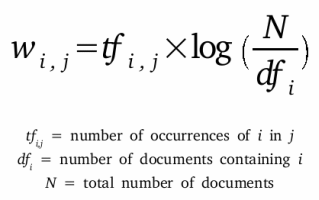

In [ ]:
#Term Frequency - Inverse Documnet Frequency
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(vectorized)
transformed_tfidf = tfidf_transformer.transform(vectorized)
print(transformed_tfidf.shape)

(2902, 33179)


#Prediction measure indices

In [ ]:
def get_metrics(predicted,true):
    metrics = dict()
    metrics['accuracy'] = round(accuracy_score(predicted, true), 5)
    metrics['precision'] = round(precision_score(predicted, true, average = 'weighted'), 5)
    metrics['recall'] = round(recall_score(predicted, true, average = 'weighted'), 5)
    metrics['f1'] = round(f1_score(predicted, true, average = 'weighted'), 5)
    
    return metrics

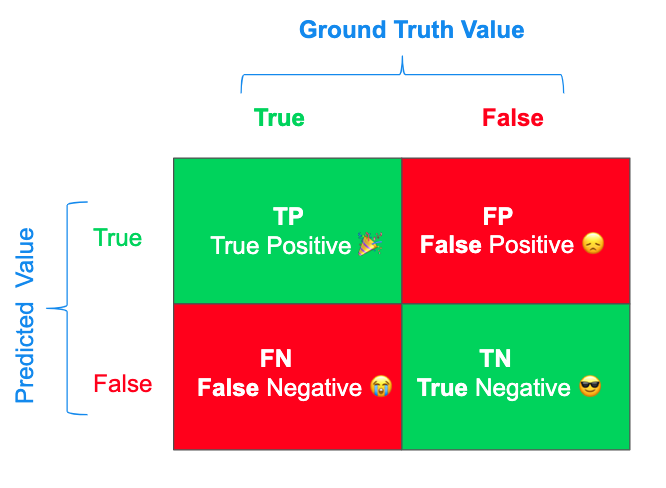

- **Accuracy**

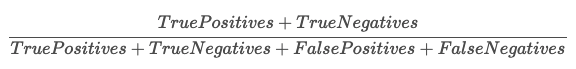

- **Precision**

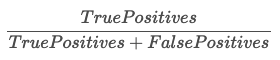

- **Recall**

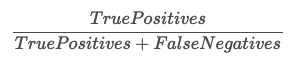

- **F1 score**

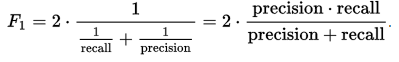

In [ ]:
models_performance_report={}

#SVM (Support Vector Machine)

In [ ]:
SVM_report={}
print(SVM_report)

{}


Metrics Sheet 

Metrics_Report={SVM_report,LR_Report,NB_Report}


In [ ]:
pipeline_SVM = Pipeline([
        ('count_vectorizer', CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2) )),  
        ('tfidf_transformer', TfidfTransformer()),  
        ('classifier', SVC(kernel='rbf', gamma=1,C=100))
    ])

parameters={
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['rbf','linear']}

#BEST
#{'classifier__C': 100, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}

In [ ]:
pipeline_SVM.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'count_vectorizer', 'tfidf_transformer', 'classifier', 'count_vectorizer__analyzer', 'count_vectorizer__binary', 'count_vectorizer__decode_error', 'count_vectorizer__dtype', 'count_vectorizer__encoding', 'count_vectorizer__input', 'count_vectorizer__lowercase', 'count_vectorizer__max_df', 'count_vectorizer__max_features', 'count_vectorizer__min_df', 'count_vectorizer__ngram_range', 'count_vectorizer__preprocessor', 'count_vectorizer__stop_words', 'count_vectorizer__strip_accents', 'count_vectorizer__token_pattern', 'count_vectorizer__tokenizer', 'count_vectorizer__vocabulary', 'tfidf_transformer__norm', 'tfidf_transformer__smooth_idf', 'tfidf_transformer__sublinear_tf', 'tfidf_transformer__use_idf', 'classifier__C', 'classifier__break_ties', 'classifier__cache_size', 'classifier__class_weight', 'classifier__coef0', 'classifier__decision_function_shape', 'classifier__degree', 'classifier__gamma', 'classifier__kernel', 'classifier__max_iter', 'cla

In [ ]:
SVM_GSCV = GridSearchCV(pipeline_SVM, parameters, cv=5, n_jobs=3, scoring="accuracy", verbose=2)

SVM_GSCV.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_SVM = SVM_GSCV.predict(testing['tweet_text_NER_STEM'])
cr=classification_report(testing['label'], prediction_SVM)
metrics_SVM = get_metrics(prediction_SVM, testing['label'])
print(cr)
print(metrics_SVM)
print(SVM_GSCV.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.93      0.88      0.90       488
        True       0.88      0.93      0.91       480

    accuracy                           0.90       968
   macro avg       0.91      0.90      0.90       968
weighted avg       0.91      0.90      0.90       968

{'accuracy': 0.90393, 'precision': 0.90567, 'recall': 0.90393, 'f1': 0.90399}
{'classifier__C': 100, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}


NER STEM 

In [ ]:
#SVM_grid_pipeline=GridSearchCV(estimator=pipeline_SVM,param_grid=parameters,cv=10, refit = True, verbose = 1)
#SVM_grid_pipeline.fit(training['tweet_text_NER_STEM'], training['label'])
#SVM_grid_pipeline.best_params_

CV_scores = cross_val_score(pipeline_SVM, training['tweet_text_NER_STEM'], training['label'], cv=10, verbose=0)
CV_scores = [round(result, 5) for result in CV_scores]


pipeline_SVM.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_SVM = pipeline_SVM.predict(testing['tweet_text_NER_STEM'])

cr= classification_report(testing['label'], prediction_SVM)


metrics_SVM = get_metrics(prediction_SVM, testing['label'])
SVM_report["NER_STEM"]={"Performance_metrics":metrics_SVM, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(SVM_report)
#print(metrics_SVM)
with open("SVM_NER_STEM.json", "w") as output:
    json.dump(SVM_report["NER_STEM"], output)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد

              precision    recall  f1-score   support

       False       0.93      0.88      0.90       488
        True       0.88      0.93      0.91       480

    accuracy                           0.90       968
   macro avg       0.91      0.90      0.90       968
weighted avg       0.91      0.90      0.90       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.90393, 'precision': 0.90567, 'recall': 0.90393, 'f1': 0.90399}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


In [ ]:
filename = 'SVM_Level3.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

NER

In [ ]:
#SVM_grid_pipeline=GridSearchCV(estimator=pipeline_SVM,param_grid=parameters,cv=10, refit = True, verbose = 1)
#SVM_grid_pipeline.fit(training['tweet_text_NER_STEM'], training['label'])
#SVM_grid_pipeline.best_params_

#CV_scores = cross_val_score(pipeline_SVM, training['tweet_text_NER'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]


pipeline_SVM.fit(training['tweet_text_NER'], training['label'])
prediction_SVM = pipeline_SVM.predict(testing['tweet_text_NER'])

cr= classification_report(testing['label'], prediction_SVM)


metrics_SVM = get_metrics(prediction_SVM, testing['label'])
SVM_report["NER"]={"Performance_metrics":metrics_SVM, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(SVM_report)
#print(metrics_SVM)
with open("SVM_NER.json", "w") as output:
    json.dump(SVM_report["NER"], output)


              precision    recall  f1-score   support

       False       0.92      0.88      0.90       488
        True       0.88      0.93      0.90       480

    accuracy                           0.90       968
   macro avg       0.90      0.90      0.90       968
weighted avg       0.90      0.90      0.90       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.90393, 'precision': 0.90567, 'recall': 0.90393, 'f1': 0.90399}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.90186, 'precision': 0.90295, 'recall': 0.90186, 'f1': 0.9019}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


In [ ]:
filename = 'SVM_Level2.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

Premitive

In [ ]:
#SVM_grid_pipeline=GridSearchCV(estimator=pipeline_SVM,param_grid=parameters,cv=10, refit = True, verbose = 1)
#SVM_grid_pipeline.fit(training['tweet_text_NER_STEM'], training['label'])
#SVM_grid_pipeline.best_params_

#CV_scores = cross_val_score(pipeline_SVM, training['tweet_text'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]


pipeline_SVM.fit(training['tweet_text'], training['label'])
prediction_SVM = pipeline_SVM.predict(testing['tweet_text'])

cr= classification_report(testing['label'], prediction_SVM)


metrics_SVM = get_metrics(prediction_SVM, testing['label'])
SVM_report["PREMITIVE"]={"Performance_metrics":metrics_SVM, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(SVM_report)
#print(metrics_SVM)
with open("SVM_premitive.json", "w") as output:
    json.dump(SVM_report["PREMITIVE"], output)

              precision    recall  f1-score   support

       False       0.93      0.88      0.91       488
        True       0.89      0.94      0.91       480

    accuracy                           0.91       968
   macro avg       0.91      0.91      0.91       968
weighted avg       0.91      0.91      0.91       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.90393, 'precision': 0.90567, 'recall': 0.90393, 'f1': 0.90399}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.90186, 'precision': 0.90295, 'recall': 0.90186, 'f1': 0.9019}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'PREMITIVE': {'Perfo

In [ ]:
filename = 'SVM_Level1.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

In [ ]:
models_performance_report['SVM']=SVM_report
print(models_performance_report)

{'RF': {'NER_STEM': {'Performance_metrics': {'accuracy': 0.88843, 'precision': 0.89502, 'recall': 0.88843, 'f1': 0.88875}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.82687, 0.8553, 0.87339, 0.85013, 0.86047, 0.84755, 0.85271, 0.85271, 0.87597], 'MIN': 0.82687, 'MAX': 0.87597, 'Mean': 0.85426, 'SD': 0.01319}}, 'NER': {'Performance_metrics': {'accuracy': 0.87397, 'precision': 0.87495, 'recall': 0.87397, 'f1': 0.87401}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84238, 0.81137, 0.84496, 0.87339, 0.8553, 0.84238, 0.84238, 0.86822, 0.85271, 0.83979], 'MIN': 0.81137, 'MAX': 0.87339, 'Mean': 0.84729, 'SD': 0.01624}}, 'PRIMITIVE': {'Performance_metrics': {'accuracy': 0.88636, 'precision': 0.88702, 'recall': 0.88636, 'f1': 0.88639}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.8708, 0.83721, 0.84238, 0.87855, 0.84755, 0.86563, 0.86563, 0.86563, 0.8553, 0.8553], 'MIN': 0.83721, 'MAX': 0.87855, 'Mean': 0.8584, 'SD': 0.01249}}}, 'SVM': {'NE

# Logistic Regression

In [ ]:
pipeline_LR = Pipeline([
        ('count_vectorizer', CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))),  
        ('tfidf_transformer', TfidfTransformer()),  
        ('classifier', LogisticRegression())
    ])

LR_report={}

NER STEM

In [ ]:
#CV_scores = cross_val_score(pipeline_LR, training['tweet_text_NER_STEM'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_LR.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_LR = pipeline_LR.predict(testing['tweet_text_NER_STEM'])

cr=classification_report(testing['label'], prediction_LR)


metrics_LR = get_metrics(prediction_LR, testing['label'])

LR_report["NER_STEM"]={"Performance_metrics":metrics_LR, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(LR_report)
with open("LR_NER_STEM.json", "w") as output:
    json.dump(LR_report["NER_STEM"], output)

filename = 'LR_Level3.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


              precision    recall  f1-score   support

       False       0.92      0.86      0.89       488
        True       0.86      0.93      0.89       480

    accuracy                           0.89       968
   macro avg       0.89      0.89      0.89       968
weighted avg       0.89      0.89      0.89       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.89153, 'precision': 0.89408, 'recall': 0.89153, 'f1': 0.89164}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


NER

In [ ]:
#CV_scores = cross_val_score(pipeline_LR, training['tweet_text_NER'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_LR.fit(training['tweet_text_NER'], training['label'])
prediction_LR = pipeline_LR.predict(testing['tweet_text_NER'])

cr=classification_report(testing['label'], prediction_LR)


metrics_LR = get_metrics(prediction_LR, testing['label'])

LR_report["NER"]={"Performance_metrics":metrics_LR, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(LR_report)
with open("LR_NER.json", "w") as output:
    json.dump(LR_report["NER"], output)

filename = 'LR_Level2.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


              precision    recall  f1-score   support

       False       0.92      0.87      0.89       488
        True       0.87      0.92      0.90       480

    accuracy                           0.89       968
   macro avg       0.90      0.89      0.89       968
weighted avg       0.90      0.89      0.89       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.89153, 'precision': 0.89408, 'recall': 0.89153, 'f1': 0.89164}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.89463, 'precision': 0.89602, 'recall': 0.89463, 'f1': 0.89468}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


Premitive

In [ ]:
#CV_scores = cross_val_score(pipeline_LR, training['tweet_text'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_LR.fit(training['tweet_text'], training['label'])
prediction_LR = pipeline_LR.predict(testing['tweet_text'])

cr=classification_report(testing['label'], prediction_LR)


metrics_LR = get_metrics(prediction_LR, testing['label'])

LR_report["PREMITIVE"]={"Performance_metrics":metrics_LR, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(LR_report)
with open("LR_PREMITIVE.json", "w") as output:
    json.dump(LR_report["PREMITIVE"], output)

filename = 'LR_Level1.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


              precision    recall  f1-score   support

       False       0.93      0.88      0.90       488
        True       0.88      0.94      0.91       480

    accuracy                           0.91       968
   macro avg       0.91      0.91      0.91       968
weighted avg       0.91      0.91      0.91       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.89153, 'precision': 0.89408, 'recall': 0.89153, 'f1': 0.89164}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.89463, 'precision': 0.89602, 'recall': 0.89463, 'f1': 0.89468}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'PREMITIVE': {'Perf

In [ ]:
models_performance_report['LR']=LR_report
print(models_performance_report)

{'SVM': {'NER_STEM': {'Performance_metrics': {'accuracy': 0.90083, 'precision': 0.90324, 'recall': 0.90083, 'f1': 0.90092}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.85013, 0.85788, 0.85271, 0.89922, 0.88114, 0.8863, 0.87855, 0.87597, 0.86822, 0.88889], 'MIN': 0.85013, 'MAX': 0.89922, 'Mean': 0.8739, 'SD': 0.01549}}, 'NER': {'Performance_metrics': {'accuracy': 0.90702, 'precision': 0.90802, 'recall': 0.90702, 'f1': 0.90706}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.87339, 0.86822, 0.86563, 0.8863, 0.87597, 0.8863, 0.88889, 0.88889, 0.8708, 0.87855], 'MIN': 0.86563, 'MAX': 0.88889, 'Mean': 0.87829, 'SD': 0.00837}}, 'PREMITIVE': {'Performance_metrics': {'accuracy': 0.91012, 'precision': 0.91187, 'recall': 0.91012, 'f1': 0.91018}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.88889, 0.87339, 0.86822, 0.89664, 0.87855, 0.90439, 0.90181, 0.89922, 0.87339, 0.88889], 'MIN': 0.86822, 'MAX': 0.90439, 'Mean': 0.88734, 'SD': 0.01251}}}, 'LR': {'N

#Naive Bayes

In [ ]:
pipeline_NB = Pipeline([
        ('count_vectorizer', CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))),  
        ('tfidf_transformer', TfidfTransformer()),  
        ('classifier', MultinomialNB())
    ])

NB_report={}

NER STEM

In [ ]:
#CV_scores = cross_val_score(pipeline_NB, training['tweet_text_NER_STEM'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_NB.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_NB = pipeline_NB.predict(testing['tweet_text_NER_STEM'])

cr=classification_report(testing['label'], prediction_NB)
metrics_NB = get_metrics(prediction_NB, testing['label'])

NB_report["NER_STEM"]={"Performance_metrics":metrics_NB, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(NB_report)
with open("NB_NER_STEM.json", "w") as output:
    json.dump(NB_report["NER_STEM"], output)


filename = 'NB_Level3.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.94      0.85      0.89       488
        True       0.86      0.94      0.90       480

    accuracy                           0.90       968
   macro avg       0.90      0.90      0.90       968
weighted avg       0.90      0.90      0.90       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.89669, 'precision': 0.90075, 'recall': 0.89669, 'f1': 0.89687}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


NER

In [ ]:
#CV_scores = cross_val_score(pipeline_NB, training['tweet_text_NER'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_NB.fit(training['tweet_text_NER'], training['label'])
prediction_NB = pipeline_NB.predict(testing['tweet_text_NER'])

cr=classification_report(testing['label'], prediction_NB)
metrics_NB = get_metrics(prediction_NB, testing['label'])

NB_report["NER"]={"Performance_metrics":metrics_NB, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(NB_report)
with open("NB_NER.json", "w") as output:
    json.dump(NB_report["NER"], output)


filename = 'NB_Level2.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

              precision    recall  f1-score   support

       False       0.94      0.86      0.90       488
        True       0.87      0.94      0.90       480

    accuracy                           0.90       968
   macro avg       0.90      0.90      0.90       968
weighted avg       0.90      0.90      0.90       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.89669, 'precision': 0.90075, 'recall': 0.89669, 'f1': 0.89687}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.90186, 'precision': 0.90472, 'recall': 0.90186, 'f1': 0.90197}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


Premitive

In [ ]:
#CV_scores = cross_val_score(pipeline_NB, training['tweet_text'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_NB.fit(training['tweet_text'], training['label'])
prediction_NB = pipeline_NB.predict(testing['tweet_text'])

cr=classification_report(testing['label'], prediction_NB)
metrics_NB = get_metrics(prediction_NB, testing['label'])

NB_report["PREMITIVE"]={"Performance_metrics":metrics_NB, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(NB_report)
with open("NB_PREMITIVE.json", "w") as output:
    json.dump(NB_report["PREMITIVE"], output)


filename = 'NB_Level1.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

              precision    recall  f1-score   support

       False       0.94      0.87      0.90       488
        True       0.88      0.94      0.91       480

    accuracy                           0.90       968
   macro avg       0.91      0.91      0.90       968
weighted avg       0.91      0.90      0.90       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.89669, 'precision': 0.90075, 'recall': 0.89669, 'f1': 0.89687}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.90186, 'precision': 0.90472, 'recall': 0.90186, 'f1': 0.90197}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'PREMITIVE': {'Perf

In [ ]:
models_performance_report['NB']=NB_report
print(models_performance_report)
with open("models_performance_report.json", "w") as output:
    json.dump(models_performance_report, output)

{'SVM': {'NER_STEM': {'Performance_metrics': {'accuracy': 0.90083, 'precision': 0.90324, 'recall': 0.90083, 'f1': 0.90092}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.85013, 0.85788, 0.85271, 0.89922, 0.88114, 0.8863, 0.87855, 0.87597, 0.86822, 0.88889], 'MIN': 0.85013, 'MAX': 0.89922, 'Mean': 0.8739, 'SD': 0.01549}}, 'NER': {'Performance_metrics': {'accuracy': 0.90702, 'precision': 0.90802, 'recall': 0.90702, 'f1': 0.90706}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.87339, 0.86822, 0.86563, 0.8863, 0.87597, 0.8863, 0.88889, 0.88889, 0.8708, 0.87855], 'MIN': 0.86563, 'MAX': 0.88889, 'Mean': 0.87829, 'SD': 0.00837}}, 'PREMITIVE': {'Performance_metrics': {'accuracy': 0.91012, 'precision': 0.91187, 'recall': 0.91012, 'f1': 0.91018}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.88889, 0.87339, 0.86822, 0.89664, 0.87855, 0.90439, 0.90181, 0.89922, 0.87339, 0.88889], 'MIN': 0.86822, 'MAX': 0.90439, 'Mean': 0.88734, 'SD': 0.01251}}}, 'LR': {'N

# Random Forest

In [ ]:
RF_report={}

In [ ]:
pipeline_RF = Pipeline([
        ('count_vectorizer', CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))),  
        ('tfidf_transformer', TfidfTransformer()),  
        ('classifier', RandomForestClassifier(random_state = 42,n_estimators=1250, max_depth=None))
    ])

#best
  #{'classifier__max_depth': None, 'classifier__n_estimators': 1250}
max_depth=[5, 8, 10, 12,16,None]
n_estimators = [100, 500,750, 1000,1250]
hyperparameters = {"classifier__max_depth":max_depth, "classifier__n_estimators":n_estimators}
##n_estimators, number of initial trees, 
#1000


NER STEM

In [ ]:
RF_GSCV = GridSearchCV(pipeline_RF, hyperparameters, cv=5, n_jobs=3, scoring="accuracy", verbose=2)

RF_GSCV.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_RF = RF_GSCV.predict(testing['tweet_text_NER_STEM'])
cr=classification_report(testing['label'], prediction_RF)
metrics_RF = get_metrics(prediction_RF, testing['label'])
print(cr)
print(metrics_RF)
print(RF_GSCV.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.94      0.83      0.88       488
        True       0.85      0.95      0.89       480

    accuracy                           0.89       968
   macro avg       0.89      0.89      0.89       968
weighted avg       0.89      0.89      0.89       968

{'accuracy': 0.88843, 'precision': 0.89502, 'recall': 0.88843, 'f1': 0.88875}
{'classifier__max_depth': None, 'classifier__n_estimators': 1250}


In [ ]:
#CV_scores = cross_val_score(pipeline_RF, training['tweet_text_NER_STEM'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_RF.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_RF = pipeline_RF.predict(testing['tweet_text_NER_STEM'])

cr=classification_report(testing['label'], prediction_RF)
metrics_RF = get_metrics(prediction_RF, testing['label'])

RF_report["NER_STEM"]={"Performance_metrics":metrics_RF, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(RF_report)
with open("RF_NER_STEM.json", "w") as output:
    json.dump(RF_report["NER_STEM"], output)

filename = 'RF_Level3.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.94      0.83      0.88       488
        True       0.85      0.95      0.89       480

    accuracy                           0.89       968
   macro avg       0.89      0.89      0.89       968
weighted avg       0.89      0.89      0.89       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.88843, 'precision': 0.89502, 'recall': 0.88843, 'f1': 0.88875}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


NER

In [ ]:
#CV_scores = cross_val_score(pipeline_RF, training['tweet_text_NER'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_RF.fit(training['tweet_text_NER'], training['label'])
prediction_RF = pipeline_RF.predict(testing['tweet_text_NER'])

cr=classification_report(testing['label'], prediction_RF)
metrics_RF = get_metrics(prediction_RF, testing['label'])

RF_report["NER"]={"Performance_metrics":metrics_RF, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(RF_report)
with open("RF_NER.json", "w") as output:
    json.dump(RF_report["NER"], output)


filename = 'RF_Level2.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

              precision    recall  f1-score   support

       False       0.89      0.85      0.87       488
        True       0.86      0.90      0.88       480

    accuracy                           0.87       968
   macro avg       0.87      0.87      0.87       968
weighted avg       0.87      0.87      0.87       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.88843, 'precision': 0.89502, 'recall': 0.88843, 'f1': 0.88875}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.87397, 'precision': 0.87495, 'recall': 0.87397, 'f1': 0.87401}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


Premitive

In [ ]:
#CV_scores = cross_val_score(pipeline_RF, training['tweet_text'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_RF.fit(training['tweet_text'], training['label'])
prediction_RF = pipeline_RF.predict(testing['tweet_text'])

cr=classification_report(testing['label'], prediction_RF)
metrics_RF = get_metrics(prediction_RF, testing['label'])

RF_report["PRIMITIVE"]={"Performance_metrics":metrics_RF, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(RF_report)
with open("RF_PRIMITIVE.json", "w") as output:
    json.dump(RF_report["PRIMITIVE"], output)

filename = 'RF_Level1.sav'
pickle.dump(pipeline_RF, open(filename, 'wb'))




              precision    recall  f1-score   support

       False       0.90      0.87      0.89       488
        True       0.87      0.90      0.89       480

    accuracy                           0.89       968
   macro avg       0.89      0.89      0.89       968
weighted avg       0.89      0.89      0.89       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.88843, 'precision': 0.89502, 'recall': 0.88843, 'f1': 0.88875}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.87397, 'precision': 0.87495, 'recall': 0.87397, 'f1': 0.87401}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'PRIMITIVE': {'Perf

In [ ]:
models_performance_report['RF']=RF_report
print(models_performance_report)
with open("models_performance_report.json", "w") as output:
    json.dump(models_performance_report, output)

{'RF': {'NER_STEM': {'Performance_metrics': {'accuracy': 0.88843, 'precision': 0.89502, 'recall': 0.88843, 'f1': 0.88875}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.82687, 0.8553, 0.87339, 0.85013, 0.86047, 0.84755, 0.85271, 0.85271, 0.87597], 'MIN': 0.82687, 'MAX': 0.87597, 'Mean': 0.85426, 'SD': 0.01319}}, 'NER': {'Performance_metrics': {'accuracy': 0.87397, 'precision': 0.87495, 'recall': 0.87397, 'f1': 0.87401}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84238, 0.81137, 0.84496, 0.87339, 0.8553, 0.84238, 0.84238, 0.86822, 0.85271, 0.83979], 'MIN': 0.81137, 'MAX': 0.87339, 'Mean': 0.84729, 'SD': 0.01624}}, 'PRIMITIVE': {'Performance_metrics': {'accuracy': 0.88636, 'precision': 0.88702, 'recall': 0.88636, 'f1': 0.88639}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.8708, 0.83721, 0.84238, 0.87855, 0.84755, 0.86563, 0.86563, 0.86563, 0.8553, 0.8553], 'MIN': 0.83721, 'MAX': 0.87855, 'Mean': 0.8584, 'SD': 0.01249}}}}


#K-Means (IGNORE)

In [ ]:
pipeline_KM = Pipeline([
        ('count_vectorizer', CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))),  
        ('tfidf_transformer', TfidfTransformer()),  
        ('classifier', KMeans(n_clusters=2, init = 'random', n_init = 10, max_iter = 300, tol = 1e-04, random_state = 0))
    ])

##

In [ ]:
pipeline_KM.fit(training['tweet_text_NER'], training['label'])
prediction_KM = pipeline_KM.predict(validation['tweet_text_NER'])

print(classification_report(validation['label'], prediction_KM))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.50      0.94      0.65       483
        True       0.52      0.07      0.12       485

    accuracy                           0.50       968
   macro avg       0.51      0.50      0.39       968
weighted avg       0.51      0.50      0.39       968



In [ ]:
pipeline_KM.fit(training['tweet_text'], training['label'])
prediction_KM = pipeline_KM.predict(validation['tweet_text'])

print(classification_report(validation['label'], prediction_KM))

              precision    recall  f1-score   support

       False       0.48      0.94      0.64       483
        True       0.00      0.00      0.00       485

    accuracy                           0.47       968
   macro avg       0.24      0.47      0.32       968
weighted avg       0.24      0.47      0.32       968



In [ ]:
metrics_KM = get_metrics(prediction_KM, testing['label'])
print(metrics_KM)
with open("KM_results.json", "w") as output:
    json.dump(metrics_KM, output)

#Decision Tree

In [ ]:
pipeline_DT = Pipeline([
        ('count_vectorizer', CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))),  
        ('tfidf_transformer', TfidfTransformer()),  
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

DT_report={}

NER STEM

In [ ]:

#CV_scores = cross_val_score(pipeline_DT, training['tweet_text_NER_STEM'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_DT.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_DT = pipeline_DT.predict(testing['tweet_text_NER_STEM'])

cr=classification_report(testing['label'], prediction_DT)
metrics_DT = get_metrics(prediction_DT, testing['label'])

DT_report["NER_STEM"]={"Performance_metrics":metrics_DT, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(DT_report)
with open("DT_NER_STEM.json", "w") as output:
    json.dump(DT_report["NER_STEM"], output)


filename = 'DT_Level3.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.81      0.80      0.81       488
        True       0.80      0.81      0.81       480

    accuracy                           0.81       968
   macro avg       0.81      0.81      0.81       968
weighted avg       0.81      0.81      0.81       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.80682, 'precision': 0.80696, 'recall': 0.80682, 'f1': 0.80682}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


NER

In [ ]:

#CV_scores = cross_val_score(pipeline_DT, training['tweet_text_NER'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_DT.fit(training['tweet_text_NER'], training['label'])
prediction_DT = pipeline_DT.predict(testing['tweet_text_NER'])

cr=classification_report(testing['label'], prediction_DT)
metrics_DT = get_metrics(prediction_DT, testing['label'])

DT_report["NER"]={"Performance_metrics":metrics_DT, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(DT_report)
with open("DT_NER.json", "w") as output:
    json.dump(DT_report["NER"], output)

filename = 'DT_Level2.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


              precision    recall  f1-score   support

       False       0.78      0.80      0.79       488
        True       0.79      0.78      0.78       480

    accuracy                           0.79       968
   macro avg       0.79      0.79      0.79       968
weighted avg       0.79      0.79      0.79       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.80682, 'precision': 0.80696, 'recall': 0.80682, 'f1': 0.80682}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.78616, 'precision': 0.78629, 'recall': 0.78616, 'f1': 0.78618}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


Premitive

In [ ]:

#CV_scores = cross_val_score(pipeline_DT, training['tweet_text'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_DT.fit(training['tweet_text'], training['label'])
prediction_DT = pipeline_DT.predict(testing['tweet_text'])

cr=classification_report(testing['label'], prediction_DT)
metrics_DT = get_metrics(prediction_DT, testing['label'])

DT_report["PREMITIVE"]={"Performance_metrics":metrics_DT, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(DT_report)
with open("DT_PREMITIVE.json", "w") as output:
    json.dump(DT_report["PREMITIVE"], output)



filename = 'DT_Level1.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


              precision    recall  f1-score   support

       False       0.82      0.83      0.82       488
        True       0.82      0.81      0.82       480

    accuracy                           0.82       968
   macro avg       0.82      0.82      0.82       968
weighted avg       0.82      0.82      0.82       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.80682, 'precision': 0.80696, 'recall': 0.80682, 'f1': 0.80682}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.78616, 'precision': 0.78629, 'recall': 0.78616, 'f1': 0.78618}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'PREMITIVE': {'Perf

In [ ]:
models_performance_report['DT']=DT_report
print(models_performance_report)
with open("models_performance_report.json", "w") as output:
    json.dump(models_performance_report, output)

{'SVM': {'NER_STEM': {'Performance_metrics': {'accuracy': 0.90083, 'precision': 0.90324, 'recall': 0.90083, 'f1': 0.90092}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.85013, 0.85788, 0.85271, 0.89922, 0.88114, 0.8863, 0.87855, 0.87597, 0.86822, 0.88889], 'MIN': 0.85013, 'MAX': 0.89922, 'Mean': 0.8739, 'SD': 0.01549}}, 'NER': {'Performance_metrics': {'accuracy': 0.90702, 'precision': 0.90802, 'recall': 0.90702, 'f1': 0.90706}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.87339, 0.86822, 0.86563, 0.8863, 0.87597, 0.8863, 0.88889, 0.88889, 0.8708, 0.87855], 'MIN': 0.86563, 'MAX': 0.88889, 'Mean': 0.87829, 'SD': 0.00837}}, 'PREMITIVE': {'Performance_metrics': {'accuracy': 0.91012, 'precision': 0.91187, 'recall': 0.91012, 'f1': 0.91018}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.88889, 0.87339, 0.86822, 0.89664, 0.87855, 0.90439, 0.90181, 0.89922, 0.87339, 0.88889], 'MIN': 0.86822, 'MAX': 0.90439, 'Mean': 0.88734, 'SD': 0.01251}}}, 'LR': {'N

#SGD(Stochastic Gradient Descent)

In [ ]:
SGD_report={}

In [ ]:
pipeline_SGD = Pipeline([
        ('count_vectorizer', CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))),  
        ('tfidf_transformer', TfidfTransformer()),  
        ('classifier', SGDClassifier())
    ])


params = {
   
    "classifier__loss" : ["hinge", "log"],
    "classifier__alpha" : [0.0001, 0.001, 0.01, 0.1, 1],
    "classifier__penalty" : ["l2", "l1", "none"],
}
'''
max_iter = [10, 50, 100,250,500,1000]
hyperparameters = {"classifier__max_depth":[10, 50, 100,250,500,1000], "classifier__n_estimators":n_estimators}'''

'\nmax_iter = [10, 50, 100,250,500,1000]\nhyperparameters = {"classifier__max_depth":[10, 50, 100,250,500,1000], "classifier__n_estimators":n_estimators}'

NER STEM

In [ ]:
SGD_GSCV = GridSearchCV(pipeline_SGD, params, cv=5, n_jobs=3, scoring="accuracy",verbose=2)

SGD_GSCV.fit(training['tweet_text_NER_STEM'].astype(str), training['label'])
prediction_SGD = SGD_GSCV.predict(testing['tweet_text_NER_STEM'])
SGD=classification_report(testing['label'], prediction_SGD)
metrics_SGD = get_metrics(prediction_SGD, testing['label'])
print(cr)
print(metrics_SGD)
print(SGD_GSCV.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.86      0.85      0.85       488
        True       0.85      0.86      0.85       480

    accuracy                           0.85       968
   macro avg       0.85      0.85      0.85       968
weighted avg       0.85      0.85      0.85       968

{'accuracy': 0.89566, 'precision': 0.89717, 'recall': 0.89566, 'f1': 0.89572}
{'classifier__alpha': 0.0001, 'classifier__loss': 'log', 'classifier__penalty': 'none'}


In [ ]:
#CV_scores = cross_val_score(pipeline_SGD, training['tweet_text_NER_STEM'], training['label'], cv=10, verbose=1, n_jobs=3)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_SGD.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_SGD = pipeline_SGD.predict(testing['tweet_text_NER_STEM'])

cr=classification_report(testing['label'], prediction_SGD)
metrics_SGD = get_metrics(prediction_SGD, testing['label'])

SGD_report["NER_STEM"]={"Performance_metrics":metrics_SGD, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(SGD_report)
with open("SGD_NER_STEM.json", "w") as output:
    json.dump(SGD_report["NER_STEM"], output)


filename = 'SGD_Level3.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.92      0.87      0.89       488
        True       0.87      0.92      0.90       480

    accuracy                           0.89       968
   macro avg       0.90      0.89      0.89       968
weighted avg       0.90      0.89      0.89       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.89463, 'precision': 0.89602, 'recall': 0.89463, 'f1': 0.89468}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


NER

In [ ]:
#CV_scores = cross_val_score(pipeline_SGD, training['tweet_text_NER'], training['label'], cv=10, verbose=1, n_jobs=3)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_SGD.fit(training['tweet_text_NER'], training['label'])
prediction_SGD = pipeline_SGD.predict(testing['tweet_text_NER'])

cr=classification_report(testing['label'], prediction_SGD)
metrics_SGD = get_metrics(prediction_SGD, testing['label'])

SGD_report["NER"]={"Performance_metrics":metrics_SGD, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(SGD_report)
with open("SGD_NER.json", "w") as output:
    json.dump(SGD_report["NER"], output)



filename = 'SGD_Level2.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))



              precision    recall  f1-score   support

       False       0.91      0.89      0.90       488
        True       0.89      0.91      0.90       480

    accuracy                           0.90       968
   macro avg       0.90      0.90      0.90       968
weighted avg       0.90      0.90      0.90       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.89463, 'precision': 0.89602, 'recall': 0.89463, 'f1': 0.89468}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.89876, 'precision': 0.89915, 'recall': 0.89876, 'f1': 0.89877}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


Premitive

In [ ]:
#CV_scores = cross_val_score(pipeline_SGD, training['tweet_text'], training['label'], cv=10, verbose=1, n_jobs=3)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_SGD.fit(training['tweet_text'], training['label'])
prediction_SGD = pipeline_SGD.predict(testing['tweet_text'])

cr=classification_report(testing['label'], prediction_SGD)
metrics_SGD = get_metrics(prediction_SGD, testing['label'])

SGD_report["PRIMITIVE"]={"Performance_metrics":metrics_SGD, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(SGD_report)
with open("SGD_PRIMITIVE.json", "w") as output:
    json.dump(SGD_report["PRIMITIVE"], output)


filename = 'SGD_Level1.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

              precision    recall  f1-score   support

       False       0.91      0.89      0.90       488
        True       0.89      0.91      0.90       480

    accuracy                           0.90       968
   macro avg       0.90      0.90      0.90       968
weighted avg       0.90      0.90      0.90       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.89463, 'precision': 0.89602, 'recall': 0.89463, 'f1': 0.89468}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.89876, 'precision': 0.89915, 'recall': 0.89876, 'f1': 0.89877}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'PRIMITIVE': {'Perf

In [ ]:
models_performance_report['SGD']=SGD_report
print(models_performance_report)
with open("models_performance_report.json", "w") as output:
    json.dump(models_performance_report, output)

{'SGD': {'NER_STEM': {'Performance_metrics': {'accuracy': 0.89566, 'precision': 0.89657, 'recall': 0.89566, 'f1': 0.89569}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.85013, 0.84496, 0.85788, 0.88889, 0.86305, 0.8863, 0.87855, 0.86563, 0.87339, 0.88889], 'MIN': 0.84496, 'MAX': 0.88889, 'Mean': 0.86977, 'SD': 0.01516}}, 'NER': {'Performance_metrics': {'accuracy': 0.90186, 'precision': 0.90231, 'recall': 0.90186, 'f1': 0.90187}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.86822, 0.8708, 0.85788, 0.88114, 0.86822, 0.8863, 0.88372, 0.88114, 0.87339, 0.86822], 'MIN': 0.85788, 'MAX': 0.8863, 'Mean': 0.8739, 'SD': 0.00848}}, 'PRIMITIVE': {'Performance_metrics': {'accuracy': 0.89979, 'precision': 0.90003, 'recall': 0.89979, 'f1': 0.8998}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.89147, 0.8863, 0.86563, 0.89664, 0.87339, 0.89664, 0.89664, 0.88114, 0.88372, 0.89406], 'MIN': 0.86563, 'MAX': 0.89664, 'Mean': 0.88656, 'SD': 0.01017}}}}


#KNN(K-Nearest Neighbors)

In [ ]:
KNN_report={}

In [ ]:
pipeline_KNN = Pipeline([
        ('count_vectorizer', CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))),  
        ('tfidf_transformer', TfidfTransformer()),  
        ('classifier', KNeighborsClassifier(n_neighbors = 20, leaf_size=30))
    ])

##best n = 20, leaf =30

leaf_size = [30,35,40,45,50]
n_neighbors = [20,25,30,25,30,35,40]
hyperparameters = {"classifier__leaf_size":leaf_size, "classifier__n_neighbors":n_neighbors}
#try 10
#25


NER STEM

In [ ]:

KNN_GSCV = GridSearchCV(pipeline_KNN, hyperparameters, cv=10, n_jobs=3)
KNN_GSCV.best_params_
KNN_GSCV.fit(training['tweet_text_NER_STEM'], training['label'])

cr=classification_report(testing['label'], KNN_GSCV)
metrics_KNN = get_metrics(prediction_DT, testing['label'])
print(cr)
print(metrics_KNN)

In [ ]:

#CV_scores = cross_val_score(pipeline_KNN, training['tweet_text_NER_STEM'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_KNN.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_KNN = pipeline_KNN.predict(testing['tweet_text_NER_STEM'])

cr=classification_report(testing['label'], prediction_KNN)
metrics_KNN = get_metrics(prediction_KNN, testing['label'])

KNN_report["NER_STEM"]={"Performance_metrics":metrics_KNN, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(KNN_report)
with open("KNN_NER_STEM.json", "w") as output:
    json.dump(KNN_report["NER_STEM"], output)


filename = 'KNN_Level3.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.91      0.84      0.87       488
        True       0.85      0.91      0.88       480

    accuracy                           0.88       968
   macro avg       0.88      0.88      0.88       968
weighted avg       0.88      0.88      0.88       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.87707, 'precision': 0.87961, 'recall': 0.87707, 'f1': 0.87719}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


In [ ]:
KNN_GSCV.best_params_

{'classifier__leaf_size': 30, 'classifier__n_neighbors': 20}

NER

In [ ]:

#CV_scores = cross_val_score(pipeline_KNN, training['tweet_text_NER'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_KNN.fit(training['tweet_text_NER'], training['label'])
prediction_KNN = pipeline_KNN.predict(testing['tweet_text_NER'])

cr=classification_report(testing['label'], prediction_KNN)
metrics_KNN = get_metrics(prediction_KNN, testing['label'])

KNN_report["NER"]={"Performance_metrics":metrics_KNN, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(KNN_report)
with open("KNN_NER.json", "w") as output:
    json.dump(KNN_report["NER"], output)


filename = 'KNN_Level2.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


              precision    recall  f1-score   support

       False       0.91      0.84      0.87       488
        True       0.85      0.91      0.88       480

    accuracy                           0.88       968
   macro avg       0.88      0.88      0.88       968
weighted avg       0.88      0.88      0.88       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.87707, 'precision': 0.87961, 'recall': 0.87707, 'f1': 0.87719}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.87707, 'precision': 0.87961, 'recall': 0.87707, 'f1': 0.87719}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}}


Premitive

In [ ]:

#CV_scores = cross_val_score(pipeline_KNN, training['tweet_text'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_KNN.fit(training['tweet_text'], training['label'])
prediction_KNN = pipeline_KNN.predict(testing['tweet_text'])

cr=classification_report(testing['label'], prediction_KNN)
metrics_KNN = get_metrics(prediction_KNN, testing['label'])

KNN_report["PRIMITIVE"]={"Performance_metrics":metrics_KNN, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(KNN_report)
with open("KNN_PRIMITIVE.json", "w") as output:
    json.dump(KNN_report["PRIMITIVE"], output)


filename = 'KNN_Level1.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


              precision    recall  f1-score   support

       False       0.91      0.84      0.87       488
        True       0.85      0.92      0.88       480

    accuracy                           0.88       968
   macro avg       0.88      0.88      0.88       968
weighted avg       0.88      0.88      0.88       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.87707, 'precision': 0.87961, 'recall': 0.87707, 'f1': 0.87719}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'NER': {'Performance_metrics': {'accuracy': 0.87707, 'precision': 0.87961, 'recall': 0.87707, 'f1': 0.87719}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84755, 0.86305, 0.85788, 0.88889, 0.86822, 0.89147, 0.87855, 0.87855, 0.8553, 0.90181], 'MIN': 0.84755, 'MAX': 0.90181, 'Mean': 0.87313, 'SD': 0.01672}}, 'PRIMITIVE': {'Perf

In [ ]:
models_performance_report['KNN']=KNN_report
print(models_performance_report)
with open("models_performance_report.json", "w") as output:
    json.dump(models_performance_report, output)

{'SVM': {'NER_STEM': {'Performance_metrics': {'accuracy': 0.90083, 'precision': 0.90324, 'recall': 0.90083, 'f1': 0.90092}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.85013, 0.85788, 0.85271, 0.89922, 0.88114, 0.8863, 0.87855, 0.87597, 0.86822, 0.88889], 'MIN': 0.85013, 'MAX': 0.89922, 'Mean': 0.8739, 'SD': 0.01549}}, 'NER': {'Performance_metrics': {'accuracy': 0.90702, 'precision': 0.90802, 'recall': 0.90702, 'f1': 0.90706}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.87339, 0.86822, 0.86563, 0.8863, 0.87597, 0.8863, 0.88889, 0.88889, 0.8708, 0.87855], 'MIN': 0.86563, 'MAX': 0.88889, 'Mean': 0.87829, 'SD': 0.00837}}, 'PREMITIVE': {'Performance_metrics': {'accuracy': 0.91012, 'precision': 0.91187, 'recall': 0.91012, 'f1': 0.91018}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.88889, 0.87339, 0.86822, 0.89664, 0.87855, 0.90439, 0.90181, 0.89922, 0.87339, 0.88889], 'MIN': 0.86822, 'MAX': 0.90439, 'Mean': 0.88734, 'SD': 0.01251}}}, 'LR': {'N

# XGBoost

In [ ]:
XGB_report= {}

In [ ]:
pipeline_XGB = Pipeline([
        ('count_vectorizer', CountVectorizer(stop_words=arabic_stop_words, ngram_range=(1,2))),  
        ('tfidf_transformer', TfidfTransformer()),  
        ('classifier', XGBClassifier())
    ])

##best n = 20, leaf =30

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

NER STEM

In [ ]:

XGB_GSCV = GridSearchCV(pipeline_XGB, params, n_jobs=3, verbose=2)

XGB_GSCV.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_XGB = XGB_GSCV.predict(testing['tweet_text_NER_STEM'])
cr=classification_report(testing['label'], prediction_XGB)
metrics_XGB = get_metrics(prediction_XGB, testing['label'])

print(cr)
print(metrics_XGB)
print(XGB_GSCV.best_params_)


filename = 'KNN_Level3.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

NameError: ignored

In [ ]:

#CV_scores = cross_val_score(pipeline_XGB, training['tweet_text_NER_STEM'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_XGB.fit(training['tweet_text_NER_STEM'], training['label'])
prediction_XGB = pipeline_XGB.predict(testing['tweet_text_NER_STEM'])

cr=classification_report(testing['label'], prediction_XGB)
metrics_XGB = get_metrics(prediction_XGB, testing['label'])

XGB_report["NER_STEM"]={"Performance_metrics":metrics_XGB, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(XGB_report)
with open("XGB_NER_STEM.json", "w") as output:
    json.dump(XGB_report["NER_STEM"], output)


filename = 'XGB_Level3.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  % sorted(inconsistent)


              precision    recall  f1-score   support

       False       0.84      0.83      0.83       488
        True       0.83      0.84      0.83       480

    accuracy                           0.83       968
   macro avg       0.83      0.83      0.83       968
weighted avg       0.83      0.83      0.83       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.83368, 'precision': 0.83376, 'recall': 0.83368, 'f1': 0.83368}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84238, 0.83204, 0.82946, 0.86305, 0.8553, 0.86305, 0.83979, 0.8553, 0.86305, 0.85013], 'MIN': 0.82946, 'MAX': 0.86305, 'Mean': 0.84935, 'SD': 0.01212}}}


NER

In [ ]:

#CV_scores = cross_val_score(pipeline_XGB, training['tweet_text_NER'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_XGB.fit(training['tweet_text_NER'], training['label'])
prediction_XGB = pipeline_XGB.predict(testing['tweet_text_NER'])

cr=classification_report(testing['label'], prediction_XGB)
metrics_XGB = get_metrics(prediction_XGB, testing['label'])

XGB_report["NER"]={"Performance_metrics":metrics_XGB, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(XGB_report)
with open("XGB_NER.json", "w") as output:
    json.dump(XGB_report["NER"], output)

filename = 'XGB_Level2.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))


              precision    recall  f1-score   support

       False       0.79      0.78      0.79       488
        True       0.78      0.79      0.79       480

    accuracy                           0.79       968
   macro avg       0.79      0.79      0.79       968
weighted avg       0.79      0.79      0.79       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.83368, 'precision': 0.83376, 'recall': 0.83368, 'f1': 0.83368}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84238, 0.83204, 0.82946, 0.86305, 0.8553, 0.86305, 0.83979, 0.8553, 0.86305, 0.85013], 'MIN': 0.82946, 'MAX': 0.86305, 'Mean': 0.84935, 'SD': 0.01212}}, 'NER': {'Performance_metrics': {'accuracy': 0.78719, 'precision': 0.7873, 'recall': 0.78719, 'f1': 0.78719}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84238, 0.83204, 0.82946, 0.86305, 0.8553, 0.86305, 0.83979, 0.8553, 0.86305, 0.85013], 'MIN': 0.82946, 'MAX': 0.86305, 'Mean': 0.84935, 'SD': 0.01212}}}


PRIMITIVE

In [ ]:

#CV_scores = cross_val_score(pipeline_XGB, training['tweet_text'], training['label'], cv=10, verbose=0)
#CV_scores = [round(result, 5) for result in CV_scores]

pipeline_XGB.fit(training['tweet_text'], training['label'])
prediction_XGB = pipeline_XGB.predict(testing['tweet_text'])

cr=classification_report(testing['label'], prediction_XGB)
metrics_XGB = get_metrics(prediction_XGB, testing['label'])

XGB_report["PRIMITIVE"]={"Performance_metrics":metrics_XGB, 
                           "Cross_validaiton_results":{"k-folds-accuracy-results":list(CV_scores),"MIN":round(min(CV_scores), 5), 
                                                       "MAX":round(max(CV_scores),5), "Mean":round(np.mean(CV_scores),5), "SD":round(np.std(CV_scores),5)}}
print(cr)
print(XGB_report)
with open("XGB_PRIMITIVE.json", "w") as output:
    json.dump(XGB_report["PRIMITIVE"], output)


filename = 'XGB_Level1.sav'
dir='/content/drive/MyDrive/Capstone Project Files CS/Models/'
pickle.dump(pipeline_SVM, open(dir+filename, 'wb'))

              precision    recall  f1-score   support

       False       0.81      0.85      0.83       488
        True       0.84      0.79      0.81       480

    accuracy                           0.82       968
   macro avg       0.82      0.82      0.82       968
weighted avg       0.82      0.82      0.82       968

{'NER_STEM': {'Performance_metrics': {'accuracy': 0.83368, 'precision': 0.83376, 'recall': 0.83368, 'f1': 0.83368}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84238, 0.83204, 0.82946, 0.86305, 0.8553, 0.86305, 0.83979, 0.8553, 0.86305, 0.85013], 'MIN': 0.82946, 'MAX': 0.86305, 'Mean': 0.84935, 'SD': 0.01212}}, 'NER': {'Performance_metrics': {'accuracy': 0.78719, 'precision': 0.7873, 'recall': 0.78719, 'f1': 0.78719}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.84238, 0.83204, 0.82946, 0.86305, 0.8553, 0.86305, 0.83979, 0.8553, 0.86305, 0.85013], 'MIN': 0.82946, 'MAX': 0.86305, 'Mean': 0.84935, 'SD': 0.01212}}, 'PRIMITIVE': {'Perform

In [ ]:
models_performance_report['XGB']=XGB_report
print(models_performance_report)
with open("models_performance_report.json", "w") as output:
    json.dump(models_performance_report, output)

{'SGD': {'NER_STEM': {'Performance_metrics': {'accuracy': 0.89566, 'precision': 0.89657, 'recall': 0.89566, 'f1': 0.89569}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.85013, 0.84496, 0.85788, 0.88889, 0.86305, 0.8863, 0.87855, 0.86563, 0.87339, 0.88889], 'MIN': 0.84496, 'MAX': 0.88889, 'Mean': 0.86977, 'SD': 0.01516}}, 'NER': {'Performance_metrics': {'accuracy': 0.90186, 'precision': 0.90231, 'recall': 0.90186, 'f1': 0.90187}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.86822, 0.8708, 0.85788, 0.88114, 0.86822, 0.8863, 0.88372, 0.88114, 0.87339, 0.86822], 'MIN': 0.85788, 'MAX': 0.8863, 'Mean': 0.8739, 'SD': 0.00848}}, 'PRIMITIVE': {'Performance_metrics': {'accuracy': 0.89979, 'precision': 0.90003, 'recall': 0.89979, 'f1': 0.8998}, 'Cross_validaiton_results': {'k-folds-accuracy-results': [0.89147, 0.8863, 0.86563, 0.89664, 0.87339, 0.89664, 0.89664, 0.88114, 0.88372, 0.89406], 'MIN': 0.86563, 'MAX': 0.89664, 'Mean': 0.88656, 'SD': 0.01017}}}, 'XGB': {'NE

#Result Check JSON File and excel sheet